In [1]:
#This notebook is meant to categorise rain events from different sectors as discussed with Prof. Jai Sukhatme
#Major categories:
#1> Indian Ocean {SW,S,SE}
#2> Bay of Bengal {SE,E,NE}
#3> Arabian sea {SW,W,NW}
#4> Land based {N, NE, E, SE, S, SW, W, NW}
#5> Local
# For both land based and ocean based, a track of incoming vectors will be needed over time

In [2]:
import netCDF4 as nc
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc , patches
import scipy.interpolate as interpolate
import datetime
import pandas as pd
import scipy.signal as signal
import scipy.fft as fft
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
#functions bin:
index_lat= lambda lat: int((lat-latitude[0])/0.1)
index_lon= lambda lon: int((lon-longitude[1])/0.1)
lat= lambda index_lat: latitude[0]+index_lat*0.1
lon= lambda index_lon: longitude[0]+index_lon*0.1

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def Filter (data,cutoff,order,mode="low"):
    sos = signal.butter(order,cutoff, mode, output='sos')
    filtered = signal.sosfilt(sos, data)
    return(filtered)

def checker(point,P0,rad):
    if (point[0]-P0[0])**2 + (point[1]-P0[1])**2 <=rad:
        return True
    else:
        return False
B_points=[]
lons=[75.55+i*0.1 for i in range(20)]
lats=[11.05+i*0.1 for i in range(20)]
for y in lats:
    for x in lons:
        if checker([x,y],[77.55,13.05],2):
            B_points.append([x,y])
def points_rad(point,rad,sep):
    X=np.linspace(-rad,rad,retstep=sep)
    Y=np.linspace(-rad,rad,retstep=sep)
    points=[]
    for x in X:
        for y in Y:
            if checker(np.array([x,y]),point,rad):
                points.append(np.array([x,y]))
    return(points)
def circle_peak(dataset,circ_points):
    max_val=dataset[index_lon(circ_points[0][0]),index_lat(cicr_points[0][1])]
    point_max=circ_points[0]
    for point in circ_points:
        val=dataset[index_lon(point[0]),index_lat(point[1])]
        if val>max_val:
            point_max=point
            max_val=val
    return(max_val,point_max)
def end_judge(max_val,point_max,t_index_now):
    circ_points=points_rad(point_max,0.5,0.1)
    data=dataset[t_index_now]
    max_now=circle_peak(data,circ_points)
    if max_now(0)>=np.average(data)+0.5*np.std(data) and t_index_now>0:
        end_judge(max_now(0),max_now(1),t_index_now-1)
    else:
        return(max_now+(t_index_now,))


In [4]:
#fetching data
events_tracking=dict()
def weight(data,pt_id):
    wt=0
    try:
        for i in range(-1,2):
            for j in range(-1,2):
                try:
                    wt+=data[pt_id[0]+i,pt_id[1]+j]
                except:
                    wt=data[pt_id[0],pt_id[1]]
                    break
        return(wt)
    except:
        return(0)

for i in range(2001,2022):
    yr=str(i)
    print(yr,"...",end='')
    diri="/home/anindya/GPM_apr_aug_halfhr/"+yr+"_half_hr"
    valid_paths = next(os.walk(diri), (None, None, []))[2]
    ds=nc.Dataset(diri+"/"+valid_paths[0])
    latitude=np.array(ds['lat'][0])
    longitude=np.array(ds['lon'][0])
    def index_lat(lat):
        
        return( round((lat-latitude)/0.1))
    def index_lon(lon):
        
        return( round((lon-longitude)/0.1))

    Bangalore_lat_index=[index_lat(12.05),index_lat(14.05)]
    Bangalore_lon_index=[index_lon(76.55),index_lon(78.55)]
    
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    def Filter (data,cutoff,order,mode="low"):
        sos = signal.butter(order,cutoff, mode, output='sos')
        filtered = signal.sosfilt(sos, data)
        return(filtered)

    def checker(point,P0,rad):
        
        if (point[0]-P0[0])**2 + (point[1]-P0[1])**2 <=rad**2:
            return True
        else:
            return False
    B_points=[]
    lons=[76.55+i*0.1 for i in range(20)]
    lats=[12.05+i*0.1 for i in range(20)]
    for y in lats:
        for x in lons:
            if checker([x,y],[77.55,13.05],2**0.5):
                B_points.append([x,y])
    def points_rad(point,rad,sep):
        X=np.arange(point[0]-rad,point[0]+rad,sep)
       
        Y=np.arange(point[1]-rad,point[1]+rad,sep)
        points=[]
        for x in X:
            
            for y in Y:
                
                if checker(np.array([x,y]),point,rad):
                    points.append(np.array([float(format(x, '.2f')),float(format(y, '.2f'))]))
        return(points)
    def circle_peak(dataset,circ_points):
        pt=[index_lon(float(circ_points[0][0])),index_lat(float(circ_points[0][1]))]
        max_val=weight(dataset,pt)
        point_max=circ_points[0]
        for point in circ_points:
            val=weight(dataset,[index_lon(float(point[0])),index_lat(float(point[1]))])
            if val>=max_val:
                point_max=point
                max_val=val
        return(max_val,point_max)
    def end_judge(dataset,max_val,t_index_now,point_thread):
        print(point_thread)
        point_max=point_thread[-1]
        circ_points=points_rad(point_max,1,0.1)
        data=dataset[t_index_now,:,:]
        max_now=circle_peak(data,circ_points)
        
   
    set_times = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range(yr+'-04-01T00:00:00Z', yr+'-08-31T23:30:00Z',
                                      freq='30T'))
       .between_time('00:00','23:30')
       .index.strftime('%Y%m%d-S%H%M%S')
       .tolist())

    daily_rain_data=[]
    rain_data=[]
    for time in set_times:
        for path in valid_paths:
            if path[0]=='3' and path[21:37]==time:
                ds=nc.Dataset(diri+"/"+path)
                daily_rain_data.append(np.array(ds['precipitationCal'][:]))
                #B_pt_rain=[]
                rain_sum=0
                for point in B_points:
                    #B_pt_rain.append((point,daily_rain_data[-1][index_lon(point[0]),index_lat(point[1])]))
                    rain_sum+=daily_rain_data[-1][0,index_lon(float(point[0])),index_lat(float(point[1]))]
                rain_data.append(rain_sum)  
    
    daily_rain_data=np.array(daily_rain_data)[:,0,:,:]
    rain_data=np.array(rain_data)
    peaks,_=signal.find_peaks(rain_data)
    
    for peak in peaks:
        maxp=circle_peak(daily_rain_data[peak,:,:],B_points)
        point_thread=[]
        if maxp[0]>=np.average(daily_rain_data[peak,:,:]):
            point_thread.append(maxp[1])
        else:
            continue
        
        t_index=peak-1
        
        while t_index>0 and maxp[0]>=np.average(daily_rain_data[t_index+1,:,:])+0.25*np.std(daily_rain_data[t_index+1,:,:]) :
            
            data=daily_rain_data[t_index]
            ddd=np.linalg.norm(np.array(maxp[1])-np.array(point_thread[-1]))
            circ_points="hehe"
            if ddd>=1:
                circ_points=points_rad(maxp[1],1.2*ddd,0.1)
            else:
                circ_points=points_rad(maxp[1],1,0.1)
            maxp=circle_peak(data,circ_points)
            t_index-=1
            point_thread.append(list(maxp[1]))
        events_tracking[set_times[peak]]=point_thread[:-1]
    print('done')
    
    

2001 ...done
2002 ...done
2003 ...done
2004 ...done
2005 ...done
2006 ...done
2007 ...done
2008 ...done
2009 ...done
2010 ...done
2011 ...done
2012 ...done
2013 ...done
2014 ...done
2015 ...done
2016 ...done
2017 ...done
2018 ...done
2019 ...done
2020 ...done
2021 ...done


In [183]:
diri="/home/anindya/GPM_apr_aug_halfhr/"+'2003'+"_half_hr"
valid_paths = next(os.walk(diri), (None, None, []))[2]
ds=nc.Dataset(diri+"/"+valid_paths[0])
latitude=np.array(ds['lat'])
longitude=np.array(ds['lon'])


In [185]:
print(latitude)


[-1.45 -1.35 -1.25 -1.15 -1.05 -0.95 -0.85 -0.75 -0.65 -0.55 -0.45 -0.35
 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85
  0.95  1.05  1.15  1.25  1.35  1.45  1.55  1.65  1.75  1.85  1.95  2.05
  2.15  2.25  2.35  2.45  2.55  2.65  2.75  2.85  2.95  3.05  3.15  3.25
  3.35  3.45  3.55  3.65  3.75  3.85  3.95  4.05  4.15  4.25  4.35  4.45
  4.55  4.65  4.75  4.85  4.95  5.05  5.15  5.25  5.35  5.45  5.55  5.65
  5.75  5.85  5.95  6.05  6.15  6.25  6.35  6.45  6.55  6.65  6.75  6.85
  6.95  7.05  7.15  7.25  7.35  7.45  7.55  7.65  7.75  7.85  7.95  8.05
  8.15  8.25  8.35  8.45  8.55  8.65  8.75  8.85  8.95  9.05  9.15  9.25
  9.35  9.45  9.55  9.65  9.75  9.85  9.95 10.05 10.15 10.25 10.35 10.45
 10.55 10.65 10.75 10.85 10.95 11.05 11.15 11.25 11.35 11.45 11.55 11.65
 11.75 11.85 11.95 12.05 12.15 12.25 12.35 12.45 12.55 12.65 12.75 12.85
 12.95 13.05 13.15 13.25 13.35 13.45 13.55 13.65 13.75 13.85 13.95 14.05
 14.15 14.25 14.35 14.45 14.55 14.65 14.75 14.85 14

In [10]:
times=list(events_tracking.keys())
print(events_tracking.keys())
for t in times:
    if len(events_tracking[t])<=2:
        del events_tracking[t]

dict_keys(['20010401-S080000', '20010401-S110000', '20010401-S123000', '20010401-S133000', '20010402-S043000', '20010402-S053000', '20010402-S070000', '20010402-S110000', '20010402-S130000', '20010402-S150000', '20010402-S170000', '20010402-S183000', '20010403-S043000', '20010403-S093000', '20010403-S113000', '20010403-S123000', '20010403-S140000', '20010404-S120000', '20010405-S160000', '20010405-S170000', '20010405-S180000', '20010405-S193000', '20010405-S213000', '20010406-S163000', '20010407-S043000', '20010407-S100000', '20010407-S123000', '20010407-S133000', '20010407-S170000', '20010407-S180000', '20010407-S213000', '20010407-S223000', '20010408-S003000', '20010408-S060000', '20010408-S090000', '20010408-S120000', '20010408-S130000', '20010408-S143000', '20010408-S173000', '20010408-S190000', '20010408-S200000', '20010408-S213000', '20010408-S233000', '20010409-S003000', '20010409-S090000', '20010409-S130000', '20010409-S143000', '20010409-S170000', '20010409-S203000', '20010410

In [11]:
event_times=events_tracking.keys()
event_vectors=[]
distance=[]
duration=[]
for event in event_times:
    event_vectors.append([events_tracking[event][0][0],events_tracking[event][0][1],len(events_tracking[event])])
    distance.append(((events_tracking[event][0][0]-events_tracking[event][-1][0])**2+(events_tracking[event][0][1]-events_tracking[event][-1][1])**2)**0.5)
    duration.append(len(events_tracking[event]))
event_vectors=np.array(event_vectors)    
print(event_vectors)  

[[ 77.85  13.75   6.  ]
 [ 77.45  13.55  12.  ]
 [ 78.45  13.95  15.  ]
 ...
 [ 77.15  13.15 259.  ]
 [ 78.15  12.05 266.  ]
 [ 76.75  12.05 275.  ]]


In [ ]:
proj=ccrs.PlateCarree()
fig = plt.figure()
ax = plt.subplot(111, projection=proj)
#ax.scatter(event_vectors[:,0], event_vectors[:,1], s=2, c=event_vectors[:,2], cmap='viridis')
#for event in event_times:
plt.plot([pt[0] for pt in events_tracking['20080311-S153000']][:-1],
         [pt[1] for pt in events_tracking['20080311-S153000'][:-1]])
#ax.set_extent([longitude[0],longitude[-1],latitude[0],latitude[-1]], ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=False,dateline_direction_label=False,number_format='.0f')
ax.xaxis.set_major_formatter(lon_formatter)
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(linewidth=1, alpha=0.5)

ax.add_patch(patches.Rectangle((76.55, 12.05),2,2,
                 edgecolor = 'red',

             fill=False,
             lw=1))
plt.show()

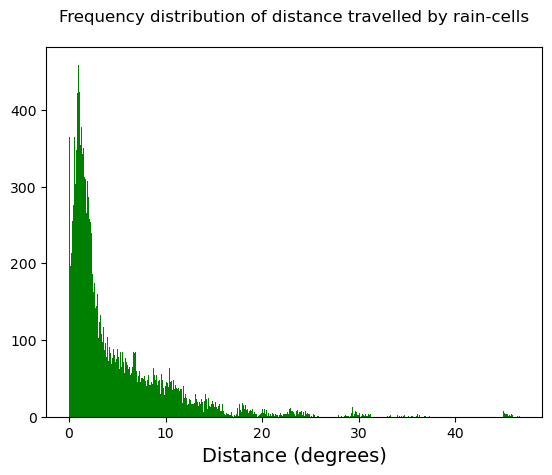

459.0 0.9333723801356026


In [13]:
nn,barr,patchh=plt.hist(distance,500,color="green")
plt.xlabel("Distance (degrees)",fontsize=14)
#plt.ylabel("Distribution",fontsize=14)
plt.title("Frequency distribution of distance travelled by rain-cells\n")
plt.show()
ln=list(nn)
print(max(ln),barr[ln.index(max(ln))])

In [14]:
from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, Feature


polygon = Polygon(
    [
        [
            (27.54,89.05),
            (34.73,76.61),
            (23.82,68.03),
            (20.77,70.40),
            (21.95,72.78),
            (16.86,73.33),
            (8.13,77.43),
            (13.21,80.45),
            (16.70,82.26),
            (21.97,88.10),
            (22.7,91.52),
            (27.54,89.05)
        ]
    ]
)
Bangalore_local=Polygon([
    [
        (11.05,75.55),
        (13.05,75.55),
        (13.05,77.55),
        (11.05,77.55)
    ]
])

for y in lats:
    for x in lons:            
        B_points.append(np.array([x,y]))
def categories(eventsDict):
    cat={"local":[],"Indian Ocean":[],"Bay Of Bengal":[],"Arabian Sea":[],"IML-N":[],"IML-S":[],"IML-E":[],"IML-W":[]}
    for event in eventsDict.keys():
        t=len(eventsDict[event])
        E=eventsDict[event][-1]
        
        S=eventsDict[event][0]
        point = Feature(geometry=Point((E[1],E[0])))
        
        if (E[1]-S[1])**2+(E[0]-S[0])**2 >=0.001:
            E=np.array(E)
            S=np.array(S)
            if boolean_point_in_polygon(point, polygon):
                if boolean_point_in_polygon(point, Bangalore_local):
                    cat["local"].append((event,E,S,t))
                    continue
                V=E-S
                if V.all()!= 0:
                
                    V=V/np.linalg.norm(V)
                    if V[1]>2**(-0.5):
                        cat["IML-N"].append((event,E,S,t)) 
                        continue
                    if V[1]<-2**(-0.5):
                        cat["IML-S"].append((event,E,S,t))
                        continue
                    if V[0]>2**(-0.5):
                        cat["IML-E"].append((event,E,S,t))
                        continue
                    if V[0]<-2**(-0.5):
                        cat["IML-W"].append((event,E,S,t))
                        continue
            else:
                if E[1]<8.1:
                    cat["Indian Ocean"].append((event,E,S,t))
                    continue
                elif E[0]>77.77:
                    cat["Bay Of Bengal"].append((event,E,S,t))
                    continue
                elif E[0]<=77.77:
                    cat["Arabian Sea"].append((event,E,S,t))
                    continue
    return(cat)
cat=categories(events_tracking)        
            

In [16]:
from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, Feature

point = Feature(geometry=Point((13.35,77.45 )))
polygon = Polygon(
    [
        [
            (27.54,89.05),
            (34.73,76.61),
            (23.82,68.03),
            (20.77,70.40),
            (21.95,72.78),
            (16.86,73.33),
            (8.13,77.43),
            (13.21,80.45),
            (16.70,82.26),
            (21.97,88.10),
            (22.7,91.52),
            (27.54,89.05)
        ]
    ]
)
boolean_point_in_polygon(point, polygon)

True

In [16]:
sorts=cat.keys()
for sort in sorts:
    print(sort, "\t",len(cat[sort]))

local 	 1851
Indian Ocean 	 1126
Bay Of Bengal 	 713
Arabian Sea 	 3575
IML-N 	 3384
IML-S 	 1294
IML-E 	 2674
IML-W 	 980


In [18]:
def indexer(s):
    d=int(s[5:8])
    dis={'4':0,'5':30,'6':61,'7':91,'8':122}
    days=dis[s[5]]+d%100-1
    tim=int(s[10:15])
    hr=tim//1000+0.5*bool(tim%1000)
    index=days*24+hr
    return(index)
indexer('20070729-S210000')

2877.0

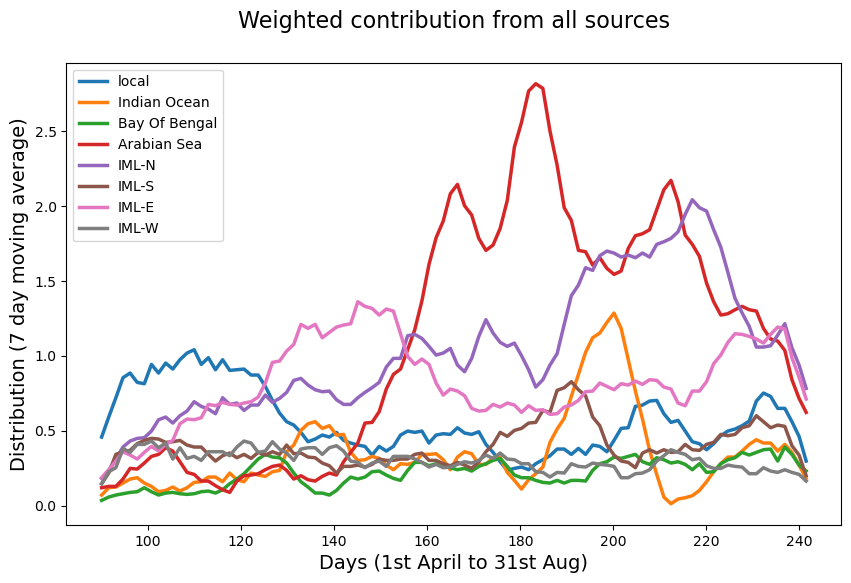

In [19]:
def moving_average(x, w,t='valid'):
    return np.convolve(x, np.ones(w), t) / w
arr=np.zeros(shape=(100,))
plt.figure(figsize=(10,6))
def cat_plotter(cat,key):
    #plots time series of each categories
    D=cat[key]
    dist_set=[]
    
    for event in D:
        index=indexer(event[0])/24
        distance=((event[1][0]-event[2][0])**2+(event[1][1]-event[2][1])**2)**0.5
        dist_set.append([index,distance,event[3]])
    dist_set=np.array(dist_set)
    n_count, bins= np.histogram(dist_set[:,0], 100, (0,3672/24),
                            density = 1)
    
    plt.plot(np.array(bins[:-1])+90*np.ones(shape=(len(bins)-1,)),len(D)*moving_average(n_count,7,"same")/21,label=key,linewidth=2.5,)
    return(len(D)*moving_average(n_count,1)/21)
for key in cat.keys(): 
    arr+=cat_plotter(cat,key)   
plt.title("Weighted contribution from all sources\n", fontsize=16)

plt.xlabel("Days (1st April to 31st Aug)",fontsize=14)
plt.ylabel("Distribution (7 day moving average)",fontsize=14)
plt.legend()
plt.show()
  


In [139]:
print(sum([len(cat[key]) for key in cat.keys()]))

15597


Text(0, 0.5, 'Distribution (3 day moving average)')

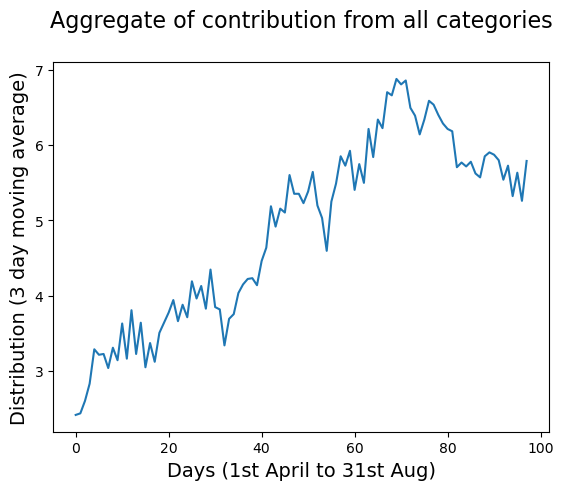

In [20]:
plt.plot(moving_average(arr,3))
plt.title("Aggregate of contribution from all categories\n", fontsize=16)
plt.xlabel("Days (1st April to 31st Aug)",fontsize=14)
plt.ylabel("Distribution (3 day moving average)",fontsize=14)


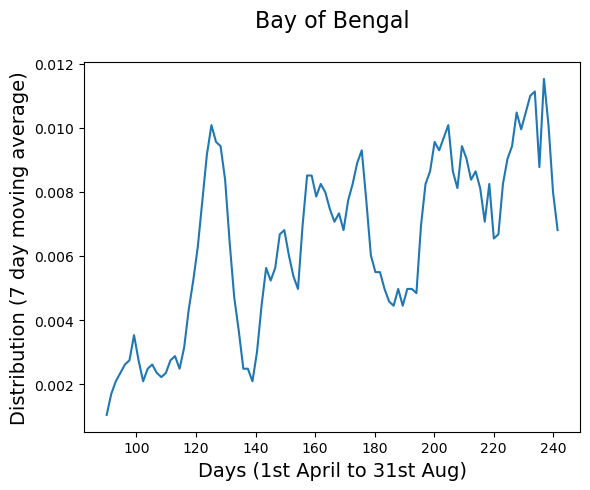

In [22]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

def cat_plotter(cat,key):
    D=cat[key]
    dist_set=[]
    
    for event in D:
        index=indexer(event[0])/24
        distance=((event[1][0]-event[2][0])**2+(event[1][1]-event[2][1])**2)**0.5
        dist_set.append([index,distance,event[3]])
    dist_set=np.array(dist_set)
    n_count, bins= np.histogram(dist_set[:,0], 100, (0,3672/24),
                            density = 1)
    
    plt.plot(np.array(bins[:-1])+90*np.ones(shape=(len(bins)-1,)),moving_average(n_count,7))
    plt.title("Bay of Bengal\n", fontsize=16)
    plt.xlabel("Days (1st April to 31st Aug)",fontsize=14)
    plt.ylabel("Distribution (7 day moving average)",fontsize=14)
cat_plotter(cat,"Bay Of Bengal")     

        

In [65]:
indexer('20070831-S233000')

3671.5